# Peter 2020 Example

Data from Peter 2020 paper: https://academic.oup.com/mbe/article/37/4/943/5645183?login=true

We perform leave-node-out prediction with FEEMS, IBD (FEEMS null model, constant edge weight), and Locator a neural network based approach to spatial prediction. 

Plots show predicted coordinates in RED. For FEEMS, predicted coordinates are the MAP assignment estimates. Black lines indicate the actual origin of each sample (or the deme closest to the sample location on the grid).

FEEMS and IBD based approaches seem to perform comparably, while Locator fairs poorly in comparison. 

"Regularized" FEEMS and IBD are fit just like regular FEEMS, except that we replace the per-deme observed frequencies with a regularized estimate of allel frequency-- essentially a convex combination of the global allele frequency and that observed from samples mapped to that deme.

In [1]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from pandas_plink import read_plink
import pickle
from glob import glob

import matplotlib.pyplot as plt
from matplotlib import collections  as mc

import cartopy.crs as ccrs
from feems import SpatialGraph, Viz
from feems.viz import project_coords
from feems.spatial_graph import query_node_attributes
from feems.cross_validation import train_test_split

In [2]:
prefix = 'popres/c1global1nfd'
grid = 250

# todo add projection values to snakemake config
projection = ccrs.PlateCarree(central_longitude=80.0)

In [3]:
grid_path = '../data/grids/grid_{grid}.shp'.format(grid=grid)
data_path = '../data/{prefix}'.format(prefix=prefix)

translated = False
output = '../output/{prefix}/feems/grid_{grid}/sp_graph.pkl'.format(prefix=prefix, grid=grid)

In [4]:
result_path_regex = lambda method, runid: \
    '../output/{prefix}/{method}/grid_{grid}/leave_node_out/{runid}/*'.format(
    prefix=prefix, method=method, grid=grid, runid=runid)

result_paths = lambda method, runid: np.sort(glob(
    '../output/{prefix}/{method}/grid_{grid}/leave_node_out/{runid}/*'.format(
    prefix=prefix, method=method, grid=grid, runid=runid)
))

In [5]:
sp_graph_path = '../output/{prefix}/feems/grid_{grid}/sp_graph.pkl'.format(prefix=prefix, grid=grid)
sp_graph = pickle.load(open(sp_graph_path, 'rb'))

coord_path = '../data/{prefix}.coord'.format(prefix=prefix)
coord = pd.read_csv(coord_path, sep='\s', header=None);

lno_coord_paths = np.sort(glob('../output/popres/c1global1nfd/feems/grid_250/leave_node_out/coord/*'))
lno_coords = [pd.read_csv(f, sep='\t', header=None) for f in lno_coord_paths]

lno_coord_paths = np.sort(glob('../output/{prefix}/locator/grid_{grid}/leave_node_out/coord/*'.format(
    prefix=prefix, grid=grid)))
lno_coords = [pd.read_csv(f, sep='\t', header=None) for f in lno_coord_paths]

/project2/jnovembre/ktayeb/spatial_prediction/spatial_prediction_workflow/.snakemake/conda/2c7cf4bb1773d38c102bc0689cd06b72/lib/python3.8/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [6]:
def draw_prediction(self, true_coord, pred_coord):
    # draw line segments
    lines = [(true_coord[i], pred_coord[i]) for i in range(pred_coord.shape[0])]
    lc = mc.LineCollection(lines, colors='k', linewidths=0.5)
    self.ax.add_collection(lc)

    # draw true coordinates
    self.ax.scatter(
        true_coord[:, 0],
        true_coord[:, 1],
        edgecolors="black",
        s=1,
        alpha=self.obs_node_alpha,
        color=self.obs_node_color,
        zorder=self.obs_node_zorder,
    )
    
    # draw predicted coordinates
    self.ax.scatter(
        pred_coord[:, 0],
        pred_coord[:, 1],
        edgecolors="red",
        color='red',
        s=1,
        alpha=self.obs_node_alpha,
        zorder=self.obs_node_zorder,
    )

def plot_predictions(true_coord, pred_coord, projection, sp_graph):
    fig = plt.figure(dpi=300)
    ax = fig.add_subplot(1, 1, 1, projection=projection)  
    v = Viz(ax, sp_graph, projection=projection, edge_width=.5, 
            edge_alpha=1, edge_zorder=100, sample_pt_size=20, 
            obs_node_size=7.5, sample_pt_color="black", 
            cbar_font_size=10)
    v.draw_map()
    v.draw_edges(use_weights=True)
    v.draw_edge_colorbar()
    
    projected_true_coord = project_coords(true_coord, v.proj)
    projected_pred_coord = project_coords(pred_coord, v.proj)
    draw_prediction(v, projected_true_coord, projected_pred_coord)
    return v

In [7]:
distances = {}

def comp_dist(a, b):
    return np.sqrt(((a - b)**2).sum(1))

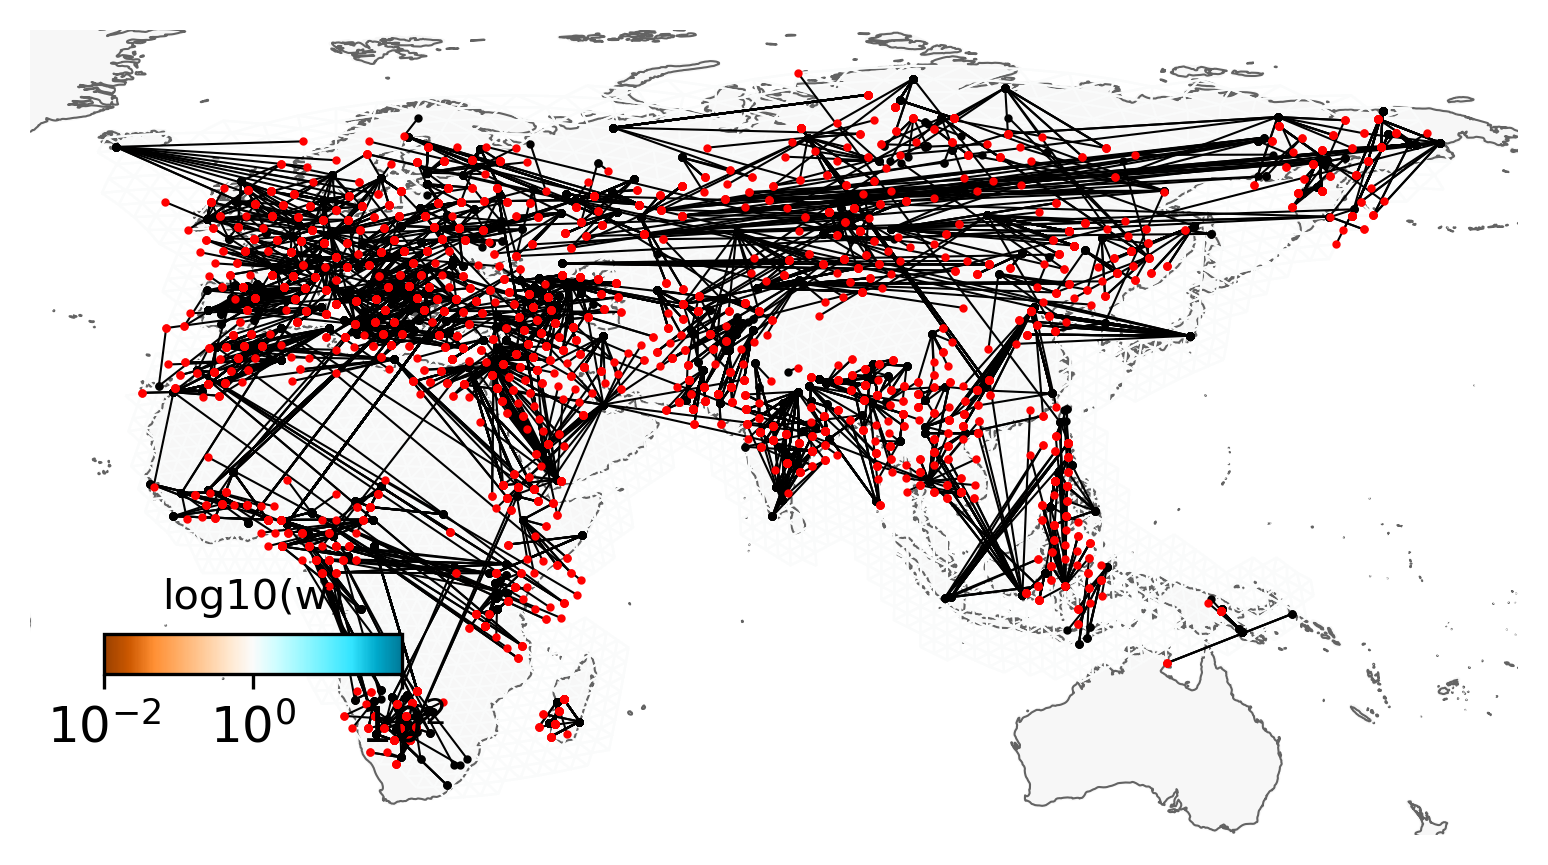

In [8]:
method = 'feems_point_noreg'
paths = result_paths('feems', method)
results = [pickle.load(open(f, 'rb')) for f in paths];

pred_coord = []
true_coord = []
for r in results:
    pred_idx = r['pred_idx']
    pred_coord.append(r['map_coord'][pred_idx])
    true_coord.append(coord.values[pred_idx])

true_coord = np.concatenate(true_coord)
pred_coord = np.concatenate(pred_coord)


distances[method] = comp_dist(true_coord, pred_coord)
plt.show(plot_predictions(true_coord, pred_coord, projection, sp_graph))

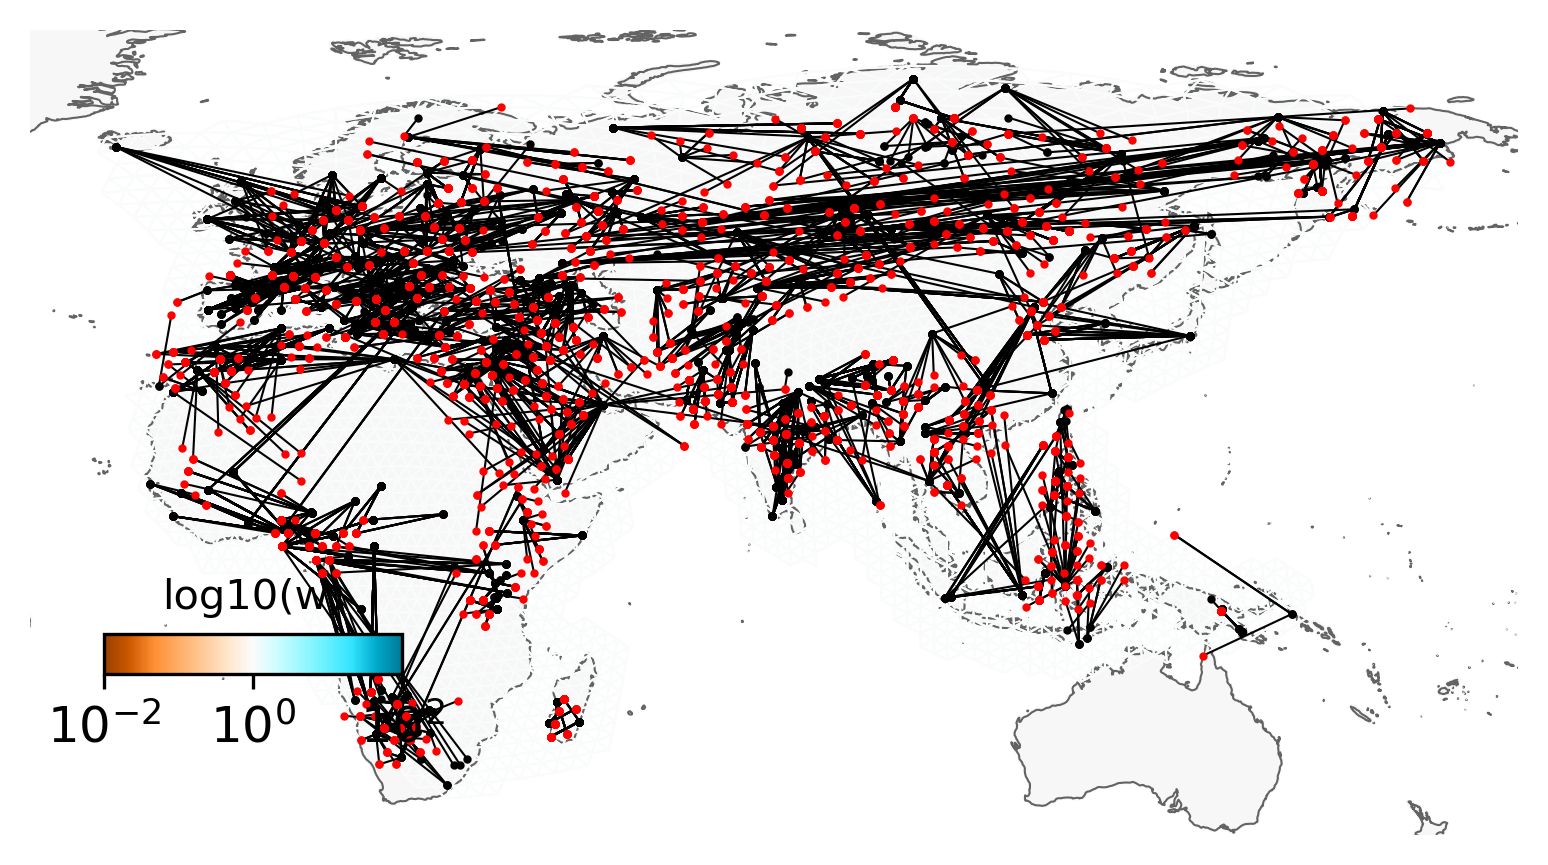

In [9]:
method = 'ibd_point_noreg'
paths = result_paths('feems', method)
results = [pickle.load(open(f, 'rb')) for f in paths];

pred_coord = []
true_coord = []
for r in results:
    pred_idx = r['pred_idx']
    pred_coord.append(r['map_coord'][pred_idx])
    true_coord.append(coord.values[pred_idx])

true_coord = np.concatenate(true_coord)
pred_coord = np.concatenate(pred_coord)


distances[method] = comp_dist(true_coord, pred_coord)
plt.show(plot_predictions(true_coord, pred_coord, projection, sp_graph))

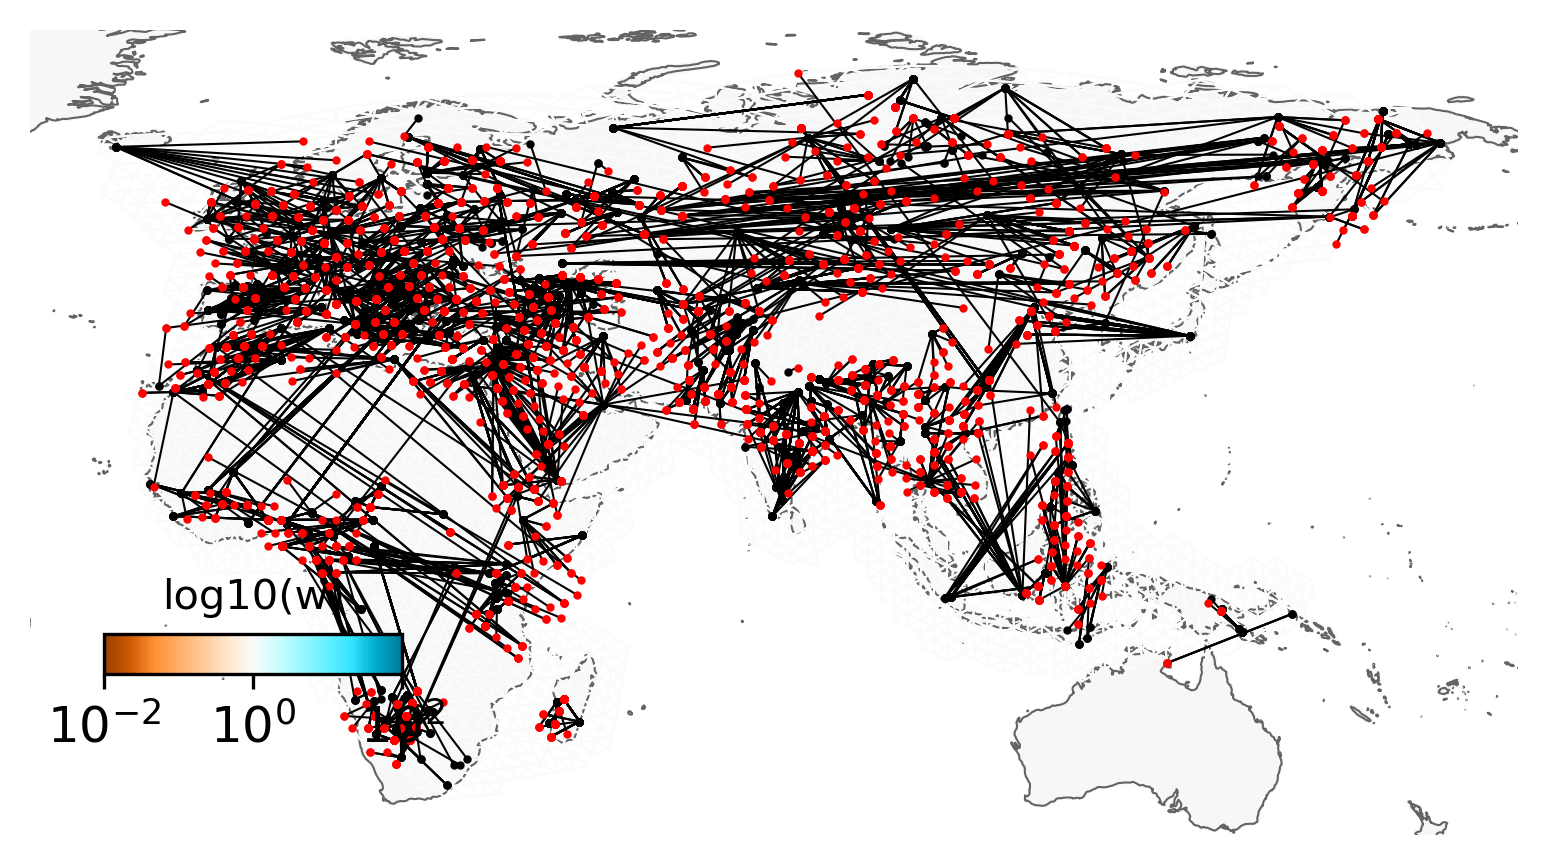

In [10]:
method = 'feems_point_alpha-0.1'
paths = result_paths('feems', method)
results = [pickle.load(open(f, 'rb')) for f in paths];

pred_coord = []
true_coord = []
for r in results:
    pred_idx = r['pred_idx']
    pred_coord.append(r['map_coord'][pred_idx])
    true_coord.append(coord.values[pred_idx])

true_coord = np.concatenate(true_coord)
pred_coord = np.concatenate(pred_coord)


distances[method] = comp_dist(true_coord, pred_coord)
plt.show(plot_predictions(true_coord, pred_coord, projection, sp_graph))

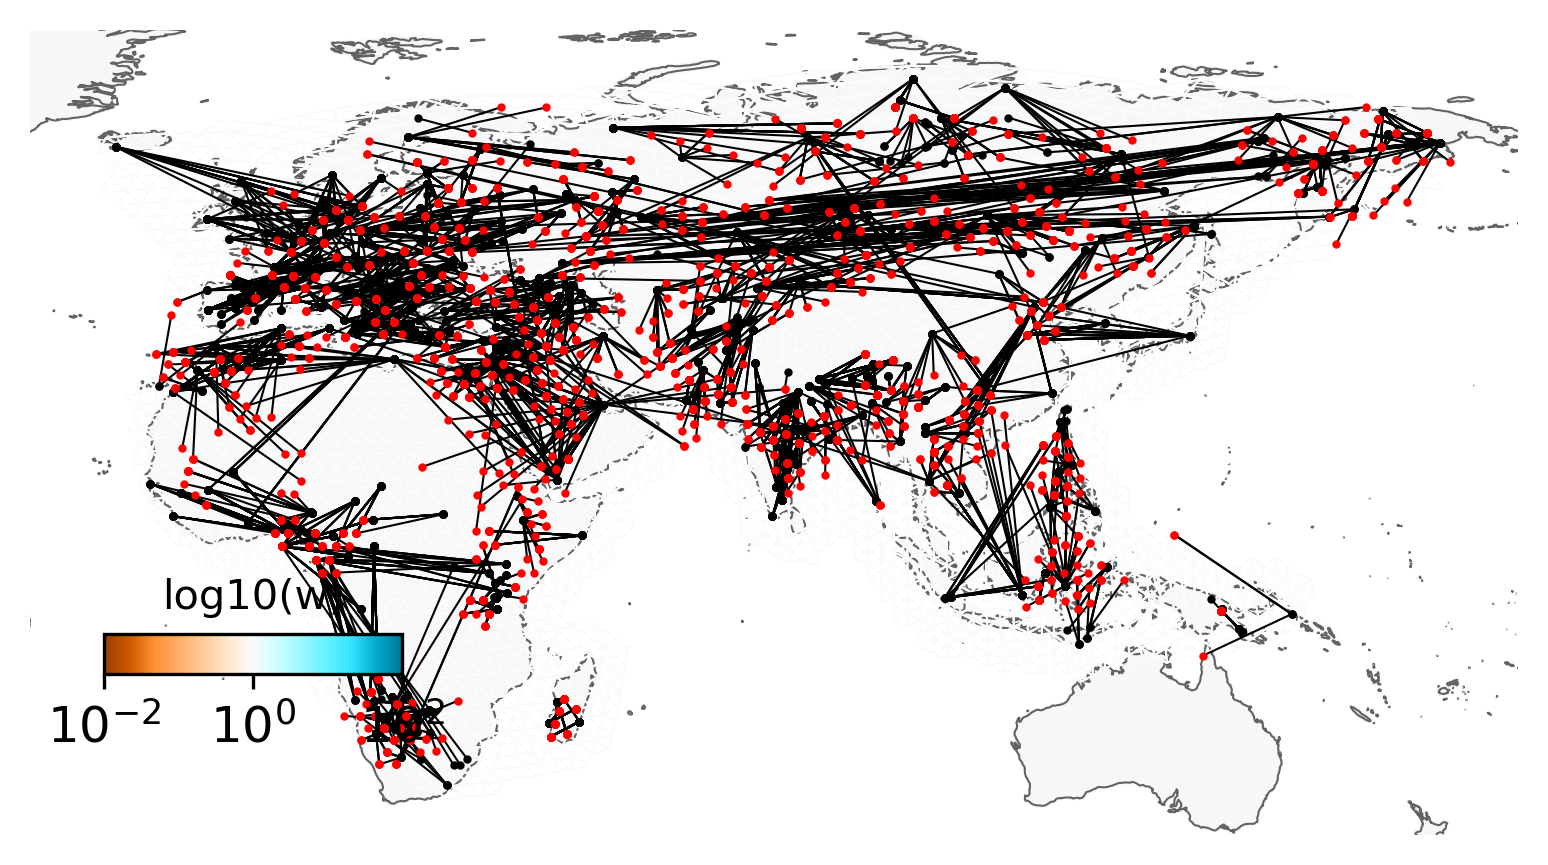

In [11]:
method = 'ibd_point_alpha-0.1'
paths = result_paths('feems', method)
results = [pickle.load(open(f, 'rb')) for f in paths];

pred_coord = []
true_coord = []
for r in results:
    pred_idx = r['pred_idx']
    pred_coord.append(r['map_coord'][pred_idx])
    true_coord.append(coord.values[pred_idx])

true_coord = np.concatenate(true_coord)
pred_coord = np.concatenate(pred_coord)


distances[method] = comp_dist(true_coord, pred_coord)
plt.show(plot_predictions(true_coord, pred_coord, projection, sp_graph))

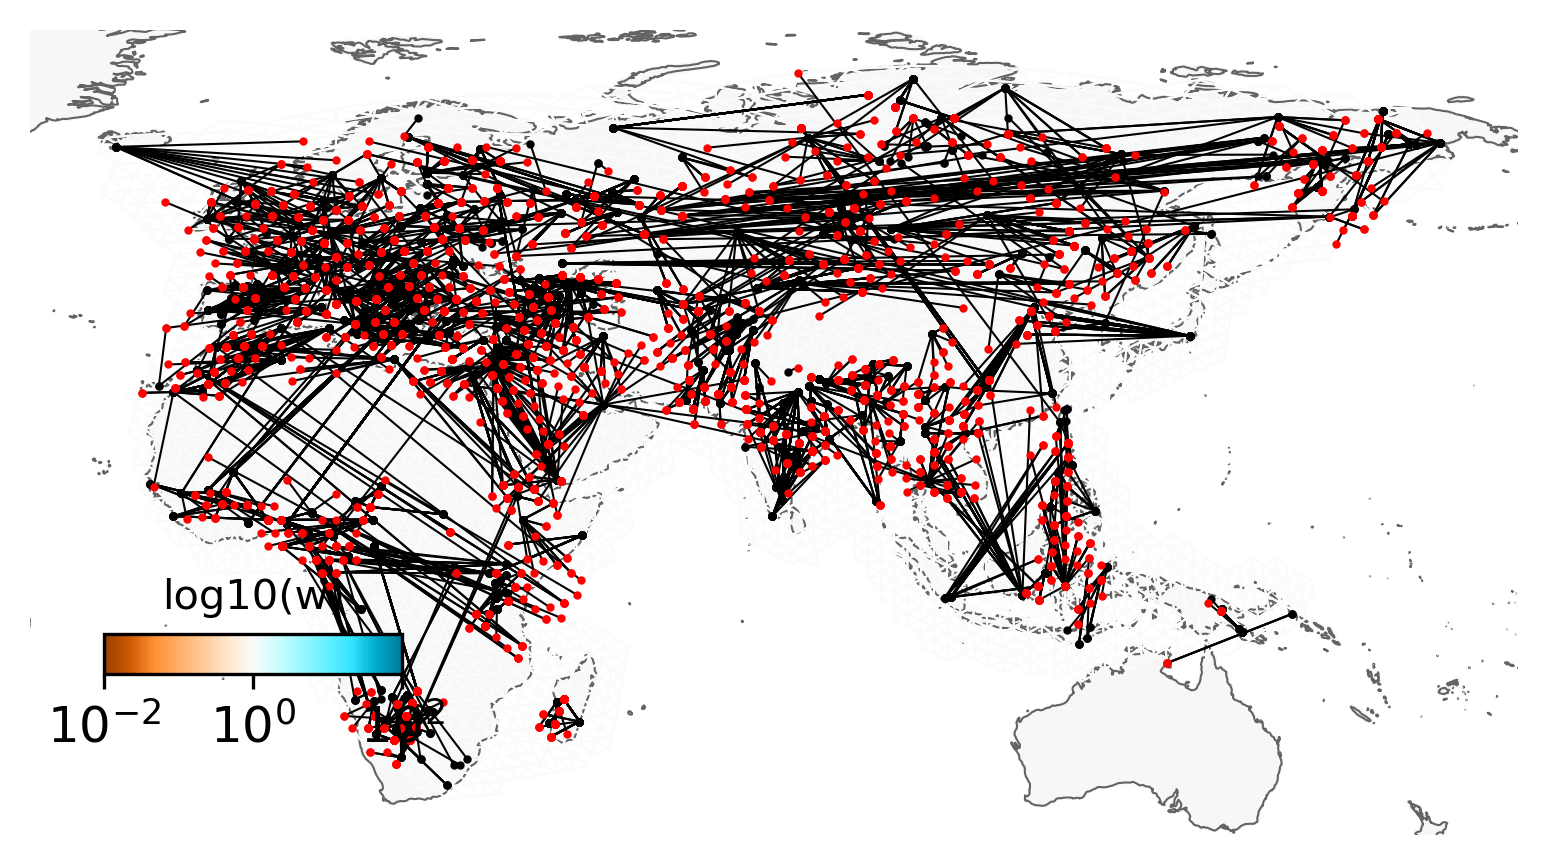

In [12]:
method = 'feems_point_alpha-0.5'
paths = result_paths('feems', method)
results = [pickle.load(open(f, 'rb')) for f in paths];

pred_coord = []
true_coord = []
for r in results:
    pred_idx = r['pred_idx']
    pred_coord.append(r['map_coord'][pred_idx])
    true_coord.append(coord.values[pred_idx])

true_coord = np.concatenate(true_coord)
pred_coord = np.concatenate(pred_coord)


distances[method] = comp_dist(true_coord, pred_coord)
plt.show(plot_predictions(true_coord, pred_coord, projection, sp_graph))

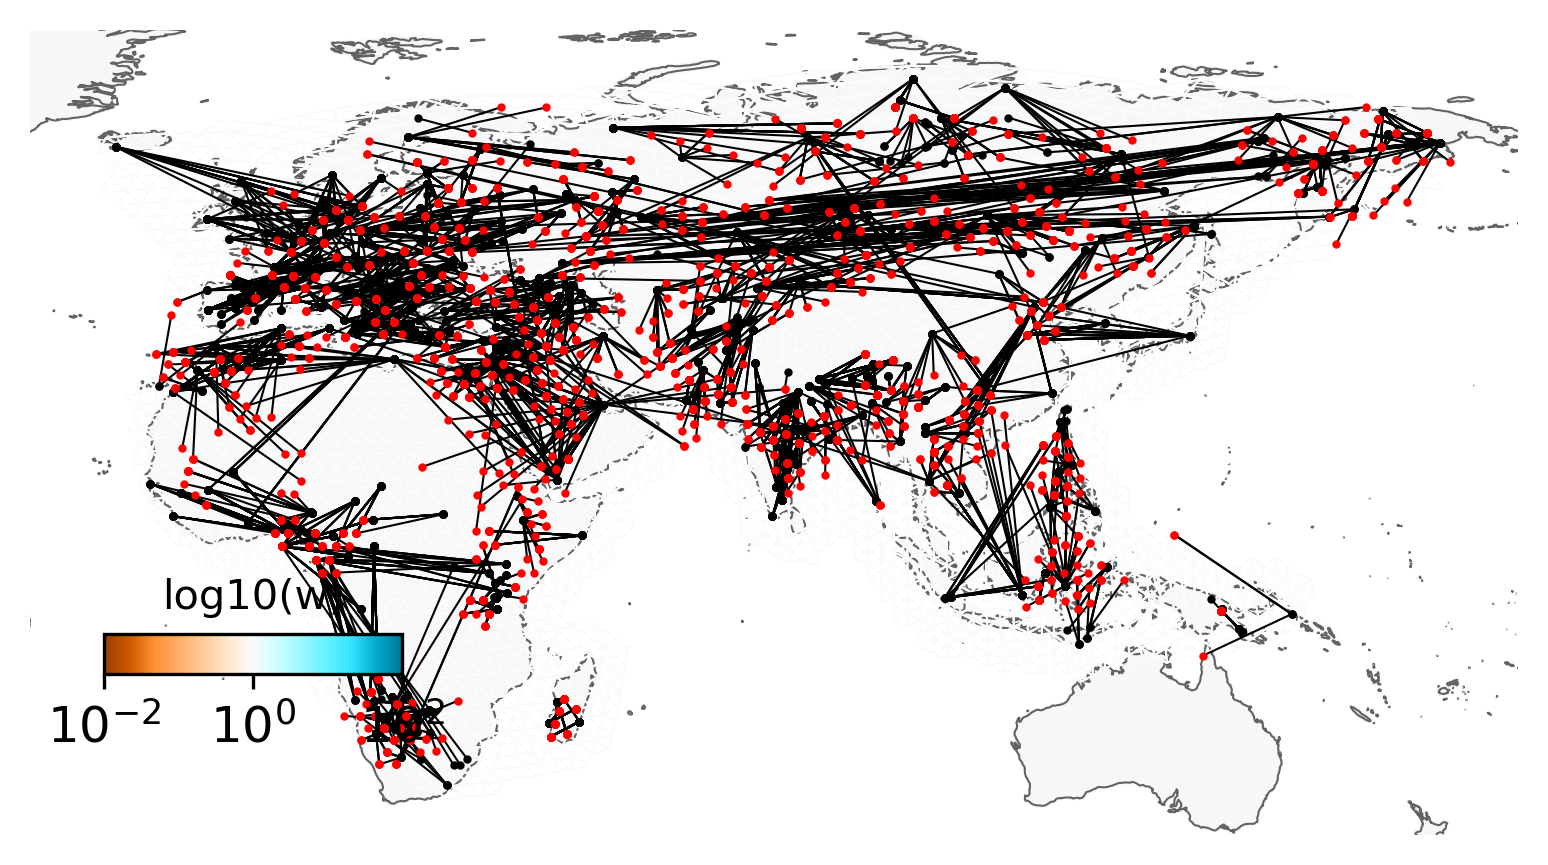

In [13]:
method = 'ibd_point_alpha-0.5'
paths = result_paths('feems', method)
results = [pickle.load(open(f, 'rb')) for f in paths];

pred_coord = []
true_coord = []
for r in results:
    pred_idx = r['pred_idx']
    pred_coord.append(r['map_coord'][pred_idx])
    true_coord.append(coord.values[pred_idx])

true_coord = np.concatenate(true_coord)
pred_coord = np.concatenate(pred_coord)


distances[method] = comp_dist(true_coord, pred_coord)
plt.show(plot_predictions(true_coord, pred_coord, projection, sp_graph))

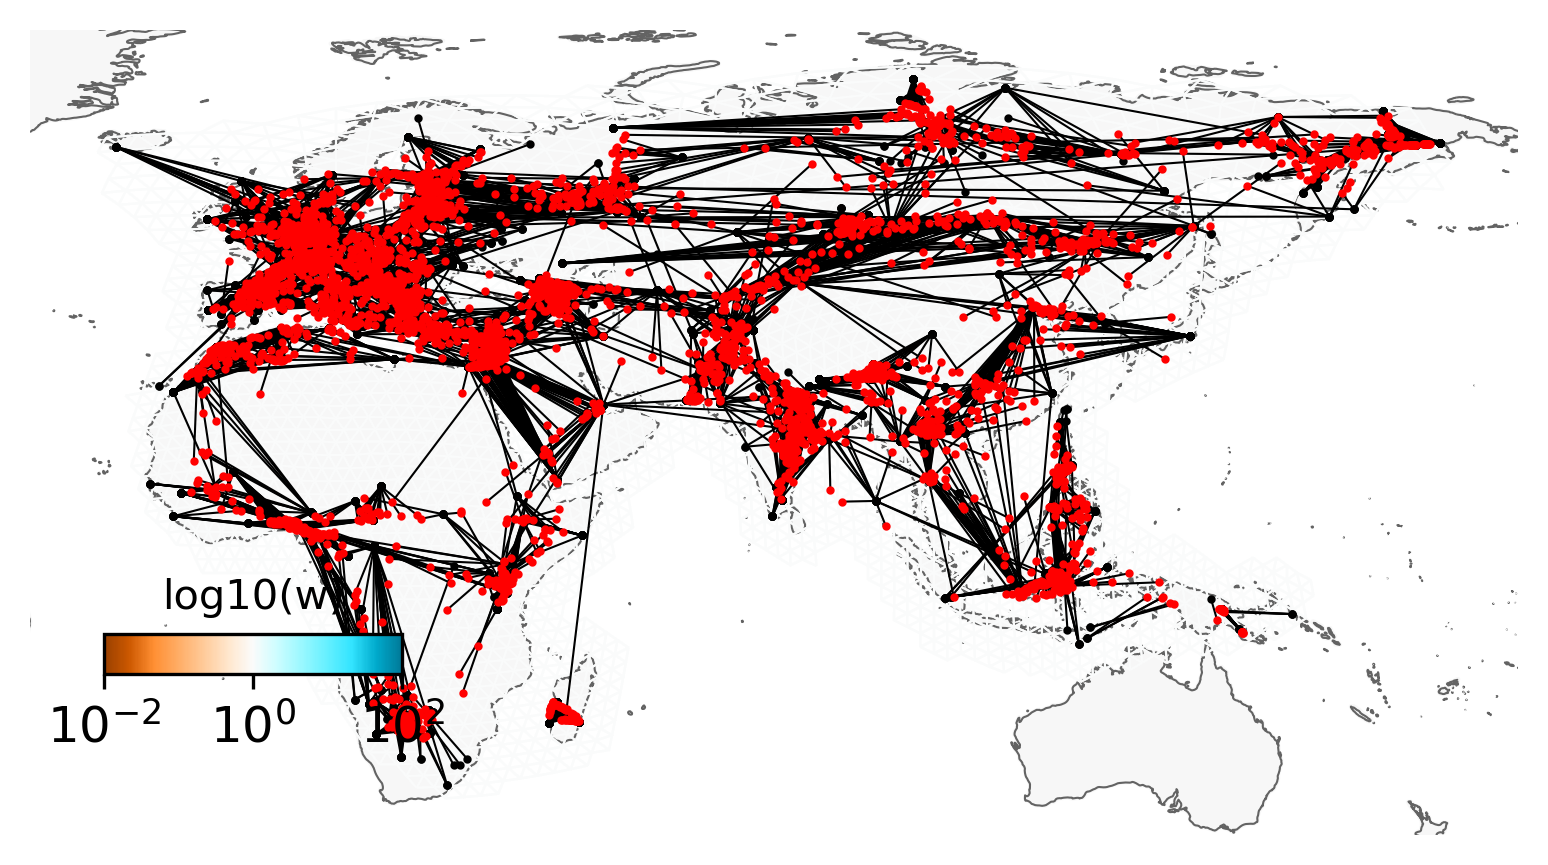

In [14]:
locator_paths = result_paths('locator', 'fit')
locator_paths = [l for l in locator_paths if 'predloc' in l]
locator_results = pd.concat([pd.read_csv(f) for f in locator_paths])
locator_results = locator_results.set_index('sampleID').sort_index()

sampleId = pd.read_csv('../output/{prefix}/locator/grid_{grid}/leave_node_out/coord/000.coord'.format(
    prefix=prefix, grid=grid), sep='\t').sampleID
coord.index = sampleId
coord_sorted = coord.sort_index()


distances['locator'] = comp_dist(coord_sorted.loc[locator_results.index].values, locator_results.values)
plt.show(plot_predictions(coord_sorted.loc[locator_results.index].values,
                          locator_results.values, projection, sp_graph))

In [28]:
d2 = {k, v for k, v in distances.items() if k in METHODS}

{'feems_point_noreg': array([11.37309566, 10.15261843, 10.15261843, ..., 10.39854918,
         5.40059423,  7.81976087]),
 'ibd_point_noreg': array([15.23075028, 15.23075028, 18.03947386, ...,  7.81976087,
         7.44715167,  9.69269008]),
 'feems_point_alpha-0.1': array([12.31248894, 12.31248894, 12.31248894, ..., 10.39854918,
         5.40059423,  7.81976087]),
 'ibd_point_alpha-0.1': array([15.23075028, 15.23075028, 18.03947386, ...,  7.81976087,
         7.44715167,  9.69269008]),
 'feems_point_alpha-0.5': array([12.31248894, 12.31248894, 12.31248894, ..., 10.39854918,
         5.40059423,  7.81976087]),
 'ibd_point_alpha-0.5': array([15.23075028, 15.23075028, 18.03947386, ...,  7.81976087,
         7.44715167,  9.69269008]),
 'locator': array([6.58849484, 6.54874139, 6.55219359, ..., 0.22755274, 5.17109877,
        5.58514911])}

In [32]:
d2

{'feems_point_noreg': array([11.37309566, 10.15261843, 10.15261843, ..., 10.39854918,
         5.40059423,  7.81976087]),
 'ibd_point_noreg': array([15.23075028, 15.23075028, 18.03947386, ...,  7.81976087,
         7.44715167,  9.69269008]),
 'locator': array([6.58849484, 6.54874139, 6.55219359, ..., 0.22755274, 5.17109877,
        5.58514911])}

### Prediction error

Boxplots show prediction error (computed as Euclidean distance) of MAP estimates from FEEMS/IBD and predictions from Locator. Methods seem to perform comparably.

We probably want to think more carefully about how we are measuring distance here.

/project2/jnovembre/ktayeb/spatial_prediction/spatial_prediction_workflow/.snakemake/conda/2c7cf4bb1773d38c102bc0689cd06b72/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


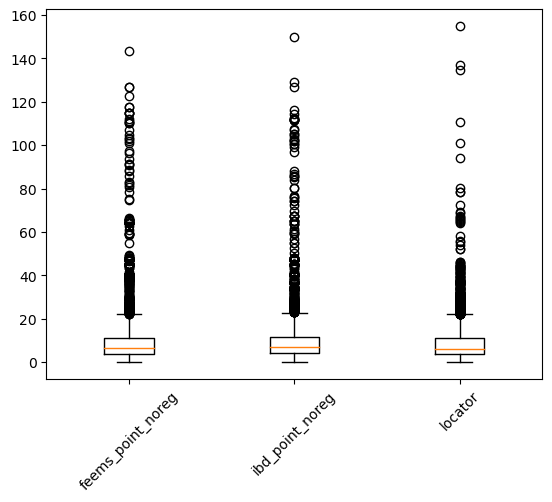

In [33]:
METHODS = [
    'feems_point_noreg',
    'ibd_point_noreg',
    'locator'
]

d2 = {k:v for k, v in distances.items() if k in METHODS}

# Python 3.5+
labels, data = [*zip(*d2.items())]  # 'transpose' items to parallel key, value lists

fig, ax = plt.subplots(1)

ax.boxplot(data)
ax.set_xticklabels(labels, rotation = 45)
plt.show()

/project2/jnovembre/ktayeb/spatial_prediction/spatial_prediction_workflow/.snakemake/conda/2c7cf4bb1773d38c102bc0689cd06b72/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


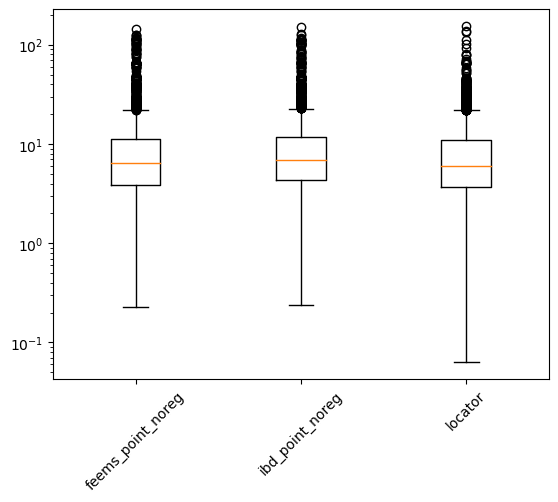

In [34]:
# Python 3.5+
labels, data = [*zip(*d2.items())]  # 'transpose' items to parallel key, value lists

fig, ax = plt.subplots(1)

ax.boxplot(data)
ax.set_xticklabels(labels, rotation = 45)
ax.set_yscale('log', basey=10)

plt.show()

In [ ]:
from feems.spatial_prediction import predict_held_out_nodes
from feems.spatial_graph import query_node_attributes

In [ ]:
sp_graph = pickle.load(open('../output/wolves/wolvesadmix/feems/grid_100/sp_graph.pkl', 'rb'))
coord = pd.read_csv('../output/wolves/wolvesadmix/feems/grid_100/leave_node_out/coord/000.coord',
                    sep='\t', header=None)

#sp_graph.fit_null_model()
#sp_graph.fit(lamb=2.0)
r=predict_held_out_nodes(sp_graph, coord, 'point')
r['w']

In [ ]:
def regularize_frequencies(self, alpha=0):
    """
    update attributes frequencies and S in self
    compute weighted average of global freuqencies
    and and observed node frequencies
    """
    n = self.n_samples_per_obs_node_permuted
    mu = self.mu
    scale = np.sqrt(mu * (1-mu))

    f = self.frequencies * scale
    f_reg = (1 - alpha / n)[:, None] * f + (alpha / n)[:, None] * mu * 2
    
    self.frequencies = f_reg / scale
    self.S = self.frequencies @ self.frequencies.T / self.n_snps

sp_graph_reg = pickle.load(open('../output/wolves/wolvesadmix/feems/grid_100/sp_graph.pkl', 'rb'))
regularize_frequencies(sp_graph_reg, 0.2)

#sp_graph_reg.fit_null_model()
#sp_graph_reg.fit(lamb=2.0)

r=predict_held_out_nodes(sp_graph_reg, coord, 'point')
r['w']

In [ ]:
sp_graph = pickle.load(open('../output/wolves/wolvesadmix/feems/grid_100/sp_graph.pkl', 'rb'))
regularize_frequencies(sp_graph, 0.0)

sample_idx = query_node_attributes(sp_graph, 'sample_idx')
permuted_idx = query_node_attributes(sp_graph, "permuted_idx")

sp_graph.fit_null_model()

# deepcopy doesn't like sp_graph.factor...
sp_graph.factor = None

# remove test demes from training
n = sp_graph.sample_pos.shape[0]
split = ~np.isnan(coord.iloc[:, 0])
sp_graph_train, sp_graph_test = train_test_split(sp_graph, split)

In [ ]:
sp_graph_reg = pickle.load(open('../output/wolves/wolvesadmix/feems/grid_100/sp_graph.pkl', 'rb'))
regularize_frequencies(sp_graph_reg, 0.2)

sample_idx = query_node_attributes(sp_graph_reg, 'sample_idx')
permuted_idx = query_node_attributes(sp_graph_reg, "permuted_idx")

sp_graph_reg.fit_null_model()

# deepcopy doesn't like sp_graph_reg.factor...
sp_graph_reg.factor = None

# remove test demes from training
n = sp_graph_reg.sample_pos.shape[0]
split = ~np.isnan(coord.iloc[:, 0])
sp_graph_reg_train, sp_graph_reg_test = train_test_split(sp_graph_reg, split)

In [ ]:
sp_graph_reg.w